# Generating Explanation Evaluation

In [2]:
import time
import pandas as pd
from tqdm import tqdm
from langchain_openai import ChatOpenAI
import lib.global_settings as settings
from ShaDoC.generate import generate_explanation
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain_cohere import ChatCohere

# import stanza
# stanza.download('zh', processors='tokenize')

import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")

# from ragas.metrics import faithfulness, answer_relevancy
from ragas import evaluate
from datasets import Dataset
import ast

# from selfcheckgpt.modeling_selfcheck_apiprompt import SelfCheckAPIPrompt
# selfcheck_prompt = SelfCheckAPIPrompt(client_type="openai", model="gpt-4o")

In [16]:
df = pd.read_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_new_part1.csv"))
df

,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth,GT_Explain,GT_Code,yt_queries,so_queries,yt_urls,yt_transcripts,so_urls,contexts,generated_explanation
0,51586693,tf.gather,example required,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www...",NaN,"<pre><code>src = tf.constant([0, 1, 1, 0], dty...",['Understanding tf.gather and tf.where in Tens...,"['Why does tf.gather(src, tf.where(src != 0)) ...",{'https://www.youtube.com/watch?v=WLtkPIrCs9Y'...,"['""""""[Document(page_content=""JASON MAYES: So\\...",{'https://stackoverflow.com/questions/37868935...,"['""""""Filter out non-zero values in a tensor\n\...","When working with TensorFlow, you may encounte..."
1,56286350,tf.keras.metrics.SensitivityAtSpecificity,example required,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...,The <code>num_thresholds</code> refers to the ...,NaN,['Understanding tf.keras.metrics.SensitivityAt...,['What is the purpose of the num_thresholds ar...,set(),[],{'https://stackoverflow.com/questions/56286350...,"['""""""tf.keras.metrics.SpecificityAtSensitivity...",The question addresses the interpretation of t...
2,74005009,tf.data.Dataset,example required,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...,If your datagen_row() function yields input_da...,<pre><code> output_signature=(\n tf.TensorSp...,['How to use tf.data.Dataset.from_generator wi...,['How to use tf.data.Dataset.from_generator wi...,set(),[],{'https://stackoverflow.com/questions/74005009...,"['""""""How to create output_signature for tensor...",To create the `output_signature` for `tf.data....
3,60013980,tf.nn.embedding_lookup_sparse,example required,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...,The most easier way to do so is to make the sp...,"<pre class=""lang-py prettyprint-override""><cod...",['How to use tf.nn.embedding_lookup_sparse wit...,['Does tf.nn.embedding_lookup_sparse support 3...,{'https://www.youtube.com/watch?v=t3z0bOsaDQ0'...,"['""""""[Document(page_content=""today i want to g...",{'https://stackoverflow.com/questions/60013980...,"['""""""tf.nn.embedding_lookup_sparse 3D sparse t...",The question addresses whether `tf.nn.embeddin...
4,57349824,tf.keras,example required,"Recurrent neural network, time series predicti...",<p>How to use new tf.keras API with recurrent ...,<p>So the answer is:</p>\n\n<pre><code>rnn_out...,"So the answer is:\n<pre><code>rnn_outputs, rnn...",NaN,['How to use tf.keras.layers.SimpleRNNCell for...,['How to use tf.keras.layers.SimpleRNNCell wit...,{'https://www.youtube.com/watch?v=Ng_uGKcWfIo'...,"['""""""[Document(page_content=""hello friends in ...",{'https://stackoverflow.com/questions/54989442...,"['""""""RNN in Tensorflow vs Keras, depreciation ...",### Description\n\nThe question addresses the ...
5,55573670,tf.nn.sparse_softmax_cross_entropy_with_logits,example required,Unexpected output for tf.nn.sparse_softmax_cro...,<p>The TensorFlow documentation for <code>tf.n...,<p>The issue is not in the lines </p>\n\n<pre>...,The issue is not in the lines \n<pre><code># I...,NaN,['Understanding tf.nn.sparse_softmax_cross_ent...,['Why does tf.nn.sparse_softmax_cross_entropy_...,set(),[],{'https://stackoverflow.com/questions/43394152...,"['""""""We can compute the cross-entropy loss on ...",The question addresses an unexpected output wh...
6,54047604,tf.custom_gradient,example required,How to assign custom gradient to TensorFlow op...,<p>I'm trying to use TensorFlow's <code>@tf.cu...,"<p>If we use multiple variables as input, the ...","If we use multiple variables as input, the num...",<pre><code>@tf.custom_gradient\ndef my_multipl...,['

In [10]:
def get_documentation(filename):

  filename_with_ext = os.path.join("/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/ShaDoC/docs", filename) + ".md"  # Add the .md extension
  try:
    with open(filename_with_ext, "r", encoding="utf-8") as file:
      content = file.read()
    return content
  except FileNotFoundError:
    raise ValueError(f"❗ DOCUMENTATION NOT FOUND.\n")

In [16]:
# def split_sent(text):
#     class Output(BaseModel):
#         sentences: list = Field(description="Sentences as a comma separated list")

#     parser = JsonOutputParser(pydantic_object=Output)
#     format_instructions = parser.get_format_instructions()

#     template = """
#         Split the entire given response into sentences and return the sentences as comma separated list of sentences.
#         {text}

#     """
#     PROMPT = PromptTemplate(
#         template=template,
#         input_variables=['text'])

#     llm=ChatCohere(model="command-r-plus", temperature=0)
#     chain = PROMPT | llm
#     prompt = {"text" : text}

#     response = chain.invoke(prompt)
#     return response

In [22]:
# def split_to_sentences(text: str):
#     nlp = stanza.Pipeline(lang='en', processors='tokenize', download_method=None, verbose=False)
#     doc = nlp(text)
#     senteces = [sentence.text for sentence in doc.sentences]
#     return senteces

### Prompt 1
Prompt the LLM with relevant information (context).

In [11]:
# results = []
# for index, row in tqdm(df.iterrows(), total=df.shape[0]):
#     documentation = get_documentation(row["QuestionAPI"])
#     solution = generate_explanation(
#         documentation=documentation, 
#         context=row["contexts"], 
#         title=row["Title"], 
#         question=row["Question"])
#     results.append({"generated_explanation":solution.content})

100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


In [ ]:
# Generated samples
# results = []
# for index, row in tqdm(df.iterrows(), total=df.shape[0]):
#     documentation = get_documentation(row["QuestionAPI"])
#     samples = []
#     for i in range(4):
#         solution = generate_explanation(
#             documentation=documentation, 
#             context=row["retrieve_contexts"], 
#             title=row["Title"], 
#             question=row["Question"])
#         samples.append(solution.content)
#     results.append({"generated_samples":samples})

In [13]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_new_part2.csv"),index=False)
merged_df

,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth,GT_Code,yt_queries,so_queries,yt_urls,yt_transcripts,so_urls,contexts,generated_explanation
0,56047272,tf.constant,example required,Explicit vs implicit type definition in Tensor...,<p>I'm just beginning to learn TensorFlow. Quo...,<blockquote>\n <p>But then it would be unnece...,NaN,"['TensorFlow tf.constant dtype inference', 'Te...",['Is it necessary to explicitly specify the dt...,{'https://www.youtube.com/watch?v=Jn5sQjYi1FU'...,NaN,{'https://stackoverflow.com/questions/61059725...,"['""""""Why does tf.constant give a dtype error i...",### Explanation of Explicit vs Implicit Type D...
1,71149271,tf.data.Dataset,example required,How to remove single feature from tensorflow d...,<p>I created dataset from csv file with datase...,<p>You can remove features by only filtering t...,<pre><code>import tensorflow as tf\nimport pan...,['How to modify a single feature in a TensorFl...,['How to modify a single feature in a TensorFl...,set(),[],{'https://stackoverflow.com/questions/52787372...,"['""""""TensorFlow: Add dimension (column) with c...",To address the questions on modifying and remo...
2,63146831,tf.custom_gradient,example required,What is the analytic interpretation for Tensor...,"<p>In the official <a href=""https://www.tensor...",<p>I finally figured it out. The <code>dy</cod...,"<pre class=""lang-py prettyprint-override""><cod...",['Understanding tf.custom_gradient in TensorFl...,['What does the grad function in tf.custom_gra...,{'https://www.youtube.com/watch?v=-0bF9tEv9YU'...,NaN,{'https://stackoverflow.com/questions/50030026...,"['""""""Does that mean in the custom gradient fun...",### Analytic Interpretation of TensorFlow Cust...
3,59998335,tf.cond,example required,Constantly update tf.cond based on bool value,<p>I am using <code>tf.cond</code> for control...,<p>You can make a placeholder for <code>foo</c...,<pre><code>import tensorflow as tf\n\ndef funa...,['How to use tf.cond with dynamic boolean valu...,['How to dynamically update the condition in t...,{'https://www.youtube.com/watch?v=IzKXEbpT9Lg'...,NaN,{'https://stackoverflow.com/questions/37063952...,"['""""""Confused by the behavior of `tf.cond`\n\n...",### Explanation Description\n\nThe question ad...
4,70747499,tf.map_fn,example required,Using tf.map_fn when the function has multiple...,<p>I can easily use tf.map_fn when the functio...,<p>You should make sure you are returning a te...,"<pre class=""lang-py prettyprint-override""><cod...",['How to use tf.map_fn with functions that ret...,['How to use tf.map_fn with a function that re...,{'https://www.youtube.com/watch?v=jipSAXT2E_I'},"['""""""[Document(page_content=""[Music] all right...",{'https://stackoverflow.com/questions/56663912...,"['""""""Can I apply tf.map_fn(...) to multiple in...",To address the question of using `tf.map_fn` w...
5,57449484,tf.compat.v1.layers.batch_normalization,example required,What is trainable parameter in tensorflow?,<p>tf.compat.v1.layers.batch_normalization tak...,"<p>First of all, this function is <a href=""htt...",NaN,"[""How does the 'trainable' parameter in tf.com...","[""How does the 'trainable' parameter in tf.com...",set(),[],{'https://stackoverflow.com/questions/58097348...,"['""""""What\'s the differences between tf.GraphK...","### Description\n\nIn TensorFlow, a trainable ..."
6,63004540,tf.pad,example required,How to pad 1 dimensinal vector in tensorflow? ...,<p>I am trying to use tf.pad. Here is my attem...,<p>You have to specify the padding at the begi...,NaN,"['How to use tf.pad in TensorFlow?', 'What is ...",['How to use tf.pad to pad a tensor to a speci...,set(),[],{'https://stackoverflow.com/questions/42334646...,"['""""""For processing, a static length makes the...","To pad a 1-dimensional vector in TensorFlow, y..."
7,62752605,tf.nn.sampled_softmax_loss,example required,Loss function in tf.nn.sampled_softmax_loss,<p>I have a question regarding Tensorflow:</p>...,"<p>Based on <a href=""https://sta

### Prompt 2
Prompt the LLM without relevant information (context)

In [ ]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    documentation = get_documentation(row["QuestionAPI"])
    solution = generate_explanation(
        title=row["Title"], 
        question=row["Question"], noContext=True)
    results.append({"no_doc_context_generated_explanation":solution.content})
    

In [ ]:
# Generated samples
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    samples = []
    for i in range(4):
        solution = generate_explanation(
            title=row["Title"], 
            question=row["Question"], noContext=True)
        samples.append(solution.content)
    results.append({"no_doc_context_generated_samples":samples})

In [ ]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)
merged_df

## Compute Hallucination

### SelfCheckGPT

In [32]:
# With context
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sentences = split_to_sentences(row["generated_explanation_y"])
    samples = ast.literal_eval(row["generated_samples"])
    sent_scores_prompt = selfcheck_prompt.predict(
        sentences = sentences,  
        sampled_passages = samples, # list of sampled passages
        verbose = False,
    )
    avg_score = average = sum(sent_scores_prompt) / len(sent_scores_prompt)
    res = {"gen_selfcheck_scores": sent_scores_prompt, "gen_selfcheck_avg_score": avg_score}
    results.append(res)

100%|██████████| 22/22 [08:49<00:00, 24.09s/it]


In [39]:
# Without context
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sentences = split_to_sentences(row["no_doc_context_generated_explanation"])
    samples = ast.literal_eval(row["no_doc_context_generated_samples"])
    sent_scores_prompt = selfcheck_prompt.predict(
        sentences = sentences,  
        sampled_passages = samples, # list of sampled passages
        verbose = False,
    )
    avg_score = average = sum(sent_scores_prompt) / len(sent_scores_prompt)
    res = {"gen_selfcheck_scores": sent_scores_prompt, "gen_selfcheck_avg_score": avg_score}
    results.append(res)


100%|██████████| 22/22 [05:04<00:00, 13.85s/it]


In [ ]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)

### RAGAS

In [ ]:
df['retrieve_contexts_new'] = df['retrieve_contexts'].apply(ast.literal_eval)
# df['Title_new'] = df['Title'].apply(lambda x: [x]) 
# contexts = df['retrieve_contexts'].tolist()

data = {"question": df["Question"], "answer": df["no_context_generated_explanation"], "contexts": df['retrieve_contexts_new']}
results = evaluate(Dataset.from_dict(data), metrics=[faithfulness, answer_relevancy])
res = results.to_pandas()
res

In [ ]:
res = res[["faithfulness", "answer_relevancy"]]
res.rename(columns={"faithfulness": "no_context_faithfulness", "answer_relevancy": "no_context_answer_relevancy"}, inplace=True)
res

In [ ]:
merged_df = df.merge(res, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)
merged_df

## Comparison

In [47]:
type(df["gen_selfcheck_avg_score"][0])

numpy.float64

/var/folders/x7/c7r5kc051js_fytcq8jbvt040000gp/T/ipykernel_4920/3912168389.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels)


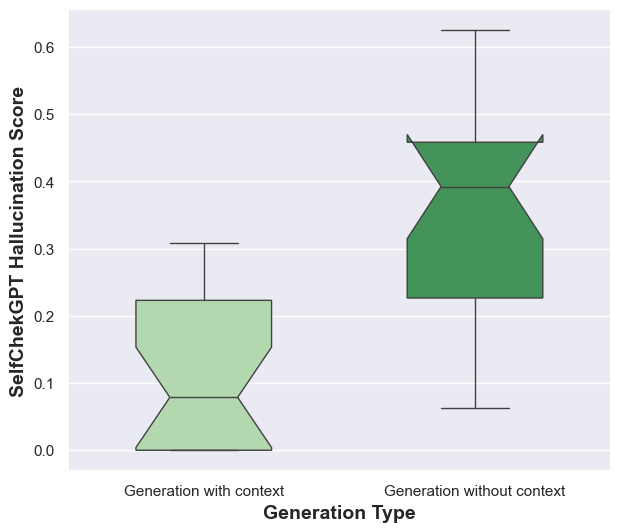

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
sns.set_theme()

df_selected = df[['gen_selfcheck_avg_score', 'no_context_gen_selfcheck_avg_score']]
df_melted = df_selected.melt(var_name='Tool', value_name='SelfCheckGPTScore')

# Create notched box plots
plt.figure(figsize=(7, 6))
ax = sns.boxplot(x='Tool', y='SelfCheckGPTScore', hue='Tool',data=df_melted, notch=True, width=0.5, palette='Greens')
custom_labels = ['Generation with context', 'Generation without context']
ax.set_xticklabels(custom_labels)
# plt.xticks(rotation=15)

# Add title and labels
# plt.title('Notched Box Plots of Tool Performance')
plt.xlabel('Generation Type', fontsize=14, fontweight='bold')
plt.ylabel('SelfChekGPT Hallucination Score', fontsize=14, fontweight='bold')
# plt.savefig('/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/figures/context_relevancy.pdf')

# Show the plot
plt.show()

# Evaluation using Accepted Answers

In [8]:
df = pd.read_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_rq2.csv"))
df

,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth,GT_Explain,GT_Code,yt_queries,so_queries,yt_urls,yt_transcripts,so_urls,contexts,generated_explanation,generated_code,execution_status,iterations
0,51586693,tf.gather,example required,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www...",I think you should use <code>tf.not_equal</cod...,"<pre><code>src = tf.constant([0, 1, 1, 0], dty...",['Understanding tf.gather and tf.where in Tens...,"['Why does tf.gather(src, tf.where(src != 0)) ...",{'https://www.youtube.com/watch?v=WLtkPIrCs9Y'...,"['""""""[Document(page_content=""JASON MAYES: So\\...",{'https://stackoverflow.com/questions/37868935...,""""""" In Tensorflow, how to use tf.gather() for ...","When working with TensorFlow, you may encounte...",This example demonstrates how to reshape a ten...,Success,1
1,56286350,tf.keras.metrics.SensitivityAtSpecificity,example required,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...,The <code>num_thresholds</code> refers to the ...,NaN,['Understanding tf.keras.metrics.SensitivityAt...,['What is the purpose of the num_thresholds ar...,set(),[],{'https://stackoverflow.com/questions/56286350...,"""""""tf.keras.metrics.SpecificityAtSensitivity n...",The question addresses the interpretation of t...,This example demonstrates how to interpret the...,Success,1
2,74005009,tf.data.Dataset,example required,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...,If your datagen_row() function yields input_da...,<pre><code> output_signature=(\n tf.TensorSp...,['How to use tf.data.Dataset.from_generator wi...,['How to use tf.data.Dataset.from_generator wi...,set(),[],{'https://stackoverflow.com/questions/74005009...,"""""""How to create output_signature for tensorfl...",To create the `output_signature` for `tf.data....,This example demonstrates how to create an out...,Success,1
3,60013980,tf.nn.embedding_lookup_sparse,example required,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...,The most easier way to do so is to make the sp...,"<pre class=""lang-py prettyprint-override""><cod...",['How to use tf.nn.embedding_lookup_sparse wit...,['Does tf.nn.embedding_lookup_sparse support 3...,{'https://www.youtube.com/watch?v=t3z0bOsaDQ0'...,"['""""""[Document(page_content=""today i want to g...",{'https://stackoverflow.com/questions/60013980...,"""""""tf.nn.embedding_lookup_sparse 3D sparse ten...",The question addresses whether `tf.nn.embeddin...,The user is trying to use tf.nn.embedding_look...,Failed,1
4,57349824,tf.keras.layers.InputLayer,example required,"Recurrent neural network, time series predicti...",<p>How to use new tf.keras API with recurrent ...,<p>So the answer is:</p>\n\n<pre><code>rnn_out...,"So the answer is:\n<pre><code>rnn_outputs, rnn...",NaN,['How to use tf.keras.layers.SimpleRNNCell for...,['How to use tf.keras.layers.SimpleRNNCell wit...,{'https://www.youtube.com/watch?v=Ng_uGKcWfIo'...,"['""""""[Document(page_content=""hello friends in ...",{'https://stackoverflow.com/questions/54989442...,"""""""RNN in Tensorflow vs Keras, depreciation of...",### Description\n\nThe question addresses the ...,import numpy as np\nimport tensorflow as tf\nf...,Failled,1
5,55573670,tf.nn.sparse_softmax_cross_entropy_with_logits,example required,Unexpected output for tf.nn.sparse_softmax_cro...,<p>The TensorFlow documentation for <code>tf.n...,<p>The issue is not in the lines </p>\n\n<pre>...,The issue is not in the lines \n<pre><code># I...,NaN,['Understanding tf.nn.sparse_softmax_cross_ent...,['Why does tf.nn.sparse_softmax_cross_entropy_...,set(),[],{'https://stackoverflow.com/questions/43394152...,""

In [9]:
from ragas.metrics import faithfulness, answer_correctness, answer_similarity

import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

from langchain_openai import ChatOpenAI
agent_llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

from ragas import evaluate
from datasets import Dataset

def compute_context_relevancy(df):
    df['contexts'] = df['contexts'].apply(lambda x: [x])
    
    data = {
    "question": df['Question'],
    "contexts": df['contexts'],
    "answer": df['generated_explanation'],
    "ground_truth": df['GT_Explain'],
    }
    metrics = [answer_correctness, answer_similarity, faithfulness]

    # # Create a Dataset object
    dataset = Dataset.from_dict(data)
    eval = evaluate(dataset, metrics=metrics)
    res = eval.to_pandas()
    return res


result = compute_context_relevancy(df)

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

In [11]:
# result.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_rq2_results.csv"), index=False)
ddf = pd.read_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_rq2_results.csv"))
# result
ddf

,question,contexts,answer,ground_truth,answer_correctness,answer_similarity,faithfulness
0,<p>When <code>src</code> has shape <code>[?]</...,"['"""""" In Tensorflow, how to use tf.gather() fo...","When working with TensorFlow, you may encounte...",I think you should use <code>tf.not_equal</cod...,0.198020,0.792081,0.500000
1,"<p>I'm trying to get my head around <a href=""h...","['""""""tf.keras.metrics.SpecificityAtSensitivity...",The question addresses the interpretation of t...,The <code>num_thresholds</code> refers to the ...,0.609004,0.936018,NaN
2,<p>I have a generator yielding data and labels...,"['""""""How to create output_signature for tensor...",To create the `output_signature` for `tf.data....,If your datagen_row() function yields input_da...,0.438894,0.898434,1.000000
3,<p>I have an embedding matrix and there is a 3...,"['""""""tf.nn.embedding_lookup_sparse 3D sparse t...",The question addresses whether `tf.nn.embeddin...,The most easier way to do so is to make the sp...,0.490199,0.835796,0.909091
4,<p>How to use new tf.keras API with recurrent ...,"['""""""RNN in Tensorflow vs Keras, depreciation ...",### Description\n\nThe question addresses the ...,"So the answer is:\n<pre><code>rnn_outputs, rnn...",0.203092,0.812366,1.000000
5,<p>The TensorFlow documentation for <code>tf.n...,"['""""""We can compute the cross-entropy loss on ...",The question addresses an unexpected output wh...,The issue is not in the lines \n<pre><code># I...,NaN,0.893381,NaN
6,<p>I'm trying to use TensorFlow's <code>@tf.cu...,"['""""""tf.custom_gradient with multiple inputs\\...",To address the question of how to assign a cus...,"If we use multiple variables as input, the num...",0.207608,0.830431,1.000000
7,<p>So I've built a convnet using pure <code>ke...,"['""""""Tensorflow 2.0: Shape inference with Resh...",### Description\n\nThis response addresses the...,There's few issues with your code. Fix them an...,0.595137,0.880547,NaN
8,<p>In the Tensorflow tf.Estimator and tf.featu...,"['""""""How do I add a new feature column to a tf...",### Description\n\nThis response addresses the...,Just found the issue:\ntf.feature_column.categ...,0.197893,0.791573,0.000000
9,<p>I am trying to understand why there is a di...,"['""""""What exactly does tf.keras.layers.Dense d...",### Understanding tf.keras.layers.Dense()\n\nT...,After some experimentation I realized that the...,0.448788,0.872075,NaN


In [12]:
result.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_rq2_results_new.csv"), index=False)
result

,question,contexts,answer,ground_truth,answer_correctness,answer_similarity,faithfulness
0,<p>When <code>src</code> has shape <code>[?]</...,"["""""" In Tensorflow, how to use tf.gather() for...","When working with TensorFlow, you may encounte...",I think you should use <code>tf.not_equal</cod...,0.784977,0.792081,1.000000
1,"<p>I'm trying to get my head around <a href=""h...","[""""""tf.keras.metrics.SpecificityAtSensitivity ...",The question addresses the interpretation of t...,The <code>num_thresholds</code> refers to the ...,0.759004,0.936018,1.000000
2,<p>I have a generator yielding data and labels...,"[""""""How to create output_signature for tensorf...",To create the `output_signature` for `tf.data....,If your datagen_row() function yields input_da...,0.787109,0.898434,1.000000
3,<p>I have an embedding matrix and there is a 3...,"[""""""tf.nn.embedding_lookup_sparse 3D sparse te...",The question addresses whether `tf.nn.embeddin...,The most easier way to do so is to make the sp...,0.333949,0.835796,1.000000
4,<p>How to use new tf.keras API with recurrent ...,"[""""""RNN in Tensorflow vs Keras, depreciation o...",### Description\n\nThe question addresses the ...,"So the answer is:\n<pre><code>rnn_outputs, rnn...",0.803092,0.812366,1.000000
5,<p>The TensorFlow documentation for <code>tf.n...,"[""""""We can compute the cross-entropy loss on a...",The question addresses an unexpected output wh...,The issue is not in the lines \n<pre><code># I...,0.460187,0.893381,1.000000
6,<p>I'm trying to use TensorFlow's <code>@tf.cu...,"[""""""tf.custom_gradient with multiple inputs\n\...",To address the question of how to assign a cus...,"If we use multiple variables as input, the num...",0.807608,0.830431,1.000000
7,<p>So I've built a convnet using pure <code>ke...,"[""""""Tensorflow 2.0: Shape inference with Resha...",### Description\n\nThis response addresses the...,There's few issues with your code. Fix them an...,0.661313,0.880547,1.000000
8,<p>In the Tensorflow tf.Estimator and tf.featu...,"[""""""How do I add a new feature column to a tf....",### Description\n\nThis response addresses the...,Just found the issue:\ntf.feature_column.categ...,0.778538,0.791684,0.000000
9,<p>I am trying to understand why there is a di...,"[""""""What exactly does tf.keras.layers.Dense do...",### Understanding tf.keras.layers.Dense()\n\nT...,After some experimentation I realized that the...,0.646564,0.872075,0.857143
